In [2]:
# %matplotlib inline
%pylab inline
import scipy
from pyiga import bspline, assemble, vform, geometry, vis, solvers
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


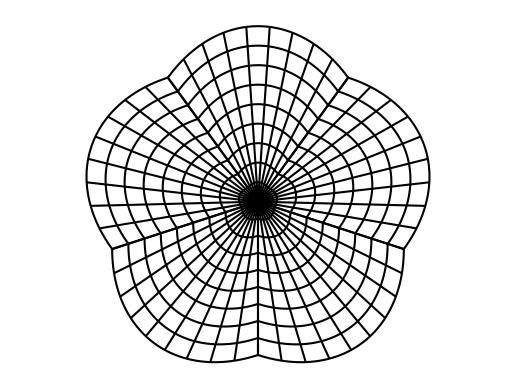

In [33]:
n = 2
f = geometry.circular_arc(pi/n)
g = geometry.line_segment([0,0], [1,1])
G = geometry.outer_product(f,g) # create pie slice
# vis.plot_geo(G)
G1 = G.rotate_2d(pi*0.25) # rotate pie slice to upright position
# vis.plot_geo(G1)
# print(pi/5)
# G2 = G1.scale([0.726,1]) # stretch pie slice in x & y-dir
# G2 = G1.scale([pi/4,1]) # stretch pie slice in x & y-dir

# vis.plot_geo(G2)

geos = [
    G2,
    G2.rotate_2d(pi*.4),
    G2.rotate_2d(2*pi*.4),
    G2.rotate_2d(3*pi*.4),
    G2.rotate_2d(4*pi*.4),
]

for g in geos:
    vis.plot_geo(g)
    
axis('equal');
axis('off');

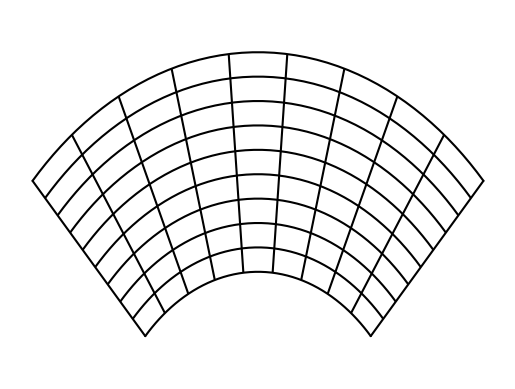

In [44]:
n = 2
f = geometry.circular_arc(pi/n)
g = geometry.line_segment([0,0], [1,1])
G = geometry.outer_product(f,g) # create pie slice
# vis.plot_geo(G)
# G1 = G.rotate_2d(pi*0.25) # rotate pie slice to upright position
# vis.plot_geo(G1)
# print(pi/5)
G2 = G1.scale([0.726,1]) # stretch pie slice in x & y-dir
# G2 = G1.scale([pi/4,1]) # stretch pie slice in x & y-dir

# vis.plot_geo(G2)

geos = [
    G2,
    # G2.rotate_2d(pi*.4),
    # G2.rotate_2d(2*pi*.4),
    # G2.rotate_2d(3*pi*.4),
    # G2.rotate_2d(4*pi*.4),
]

for g in geos:
    vis.plot_geo(g)
    
axis('equal');
axis('off');

In [51]:
# define discretization space (the same in each patch)
p = 3
kvs = 2 * (bspline.make_knots(p, 0.5, 1.0, 10),)

patches = [(kvs, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().

MP = assemble.Multipatch(patches, automatch=True)

In [46]:
# define discretization space (the same in each patch)
p = 3
kvs = 2 * (bspline.make_knots(p, 0, 1.0, 15),)

patches = [(kvs, g1) for g1 in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().

MP = assemble.Multipatch(patches, automatch=True)

In [52]:
MP.patches

[((KnotVector(array([0.5 , 0.5 , 0.5 , 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85,
          0.9 , 0.95, 1.  , 1.  , 1.  , 1.  ]), 3),
   KnotVector(array([0.5 , 0.5 , 0.5 , 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85,
          0.9 , 0.95, 1.  , 1.  , 1.  , 1.  ]), 3)),
  <pyiga.geometry.NurbsFunc at 0x20d488a5370>)]

In [55]:
# source term f and Dirichlet boundary function g
f = lambda x, y: exp(-5 * ((x-0.3)**2 + (y-1)**2))
g1 = lambda x,y: 1e-1 * sin(8*x)

# set up Dirichlet boundary conditions
bcs = MP.compute_dirichlet_bcs([
    # (0, 'bottom', g1), 
    (0, 'right', g1),
    # (1, 'top', g1),
    # (2, 'left', g1), (2, 'bottom', g1),
    # (3, 'bottom', 0),
])

# assemble the linear system
A, rhs = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [9]:
# source term f and Dirichlet boundary function g
f = lambda x, y: exp(-5 * ((x-0.3)**2 + (y-1)**2))
g = lambda x,y: 1e-1 * sin(8*x)

# set up Dirichlet boundary conditions
bcs = MP.compute_dirichlet_bcs([
    (0, 'bottom', g), (0, 'right', g),
    (1, 'top', g),
    (2, 'left', g), (2, 'bottom', g),
    (3, 'bottom', 0),
])

# assemble the linear system
A, rhs = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

[1530    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16 1531   17   18   19   20   21   22   23   24   25
   26   27   28   29   30   31   32   33 1532   34   35   36   37   38
   39   40   41   42   43   44   45   46   47   48   49   50 1533   51
   52   53   54   55   56   57   58   59   60   61   62   63   64   65
   66   67 1534   68   69   70   71   72   73   74   75   76   77   78
   79   80   81   82   83   84 1535   85   86   87   88   89   90   91
   92   93   94   95   96   97   98   99  100  101 1536  102  103  104
  105  106  107  108  109  110  111  112  113  114  115  116  117  118
 1537  119  120  121  122  123  124  125  126  127  128  129  130  131
  132  133  134  135 1538  136  137  138  139  140  141  142  143  144
  145  146  147  148  149  150  151  152 1539  153  154  155  156  157
  158  159  160  161  162  163  164  165  166  167  168  169 1540  170
  171  172  173  174  175  176  177  178  179  180  181  182  183  184
  185 

In [10]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

# restrict solution to each individual patch
u_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u)
           for p in range(len(patches))]

In [11]:
kvs

(KnotVector(array([0.5       , 0.5       , 0.5       , 0.5       , 0.53333333,
        0.56666667, 0.6       , 0.63333333, 0.66666667, 0.7       ,
        0.73333333, 0.76666667, 0.8       , 0.83333333, 0.86666667,
        0.9       , 0.93333333, 0.96666667, 1.        , 1.        ,
        1.        , 1.        ]), 3),
 KnotVector(array([0.5       , 0.5       , 0.5       , 0.5       , 0.53333333,
        0.56666667, 0.6       , 0.63333333, 0.66666667, 0.7       ,
        0.73333333, 0.76666667, 0.8       , 0.83333333, 0.86666667,
        0.9       , 0.93333333, 0.96666667, 1.        , 1.        ,
        1.        , 1.        ]), 3))

In [12]:
figsize(8,6)

for (u_func, (kvs, geo)) in zip(u_funcs, patches):
    vis.plot_field(u_func, geo, vmin=0, vmax=1.5e-1)
axis('scaled')
colorbar();

ValueError: negative column index found